In [77]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go
import numpy as np
import tensorflow as tf
np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import pandas as pd


In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
train=pd.read_csv('/content/drive/MyDrive/Yahoodataset/synthetic_1.csv')

In [80]:
train['value']

0        13.894031
1        33.578274
2        88.933746
3       125.389424
4       152.962000
           ...    
1416   -141.419766
1417   -139.657834
1418    -70.550652
1419    -16.857148
1420      7.757660
Name: value, Length: 1421, dtype: float64

In [81]:
train

,timestamp,value,is_anomaly
0,1416726000,13.894031,0
1,1416729600,33.578274,0
2,1416733200,88.933746,0
3,1416736800,125.389424,0
4,1416740400,152.962000,0
...,...,...,...
1416,1421823600,-141.419766,0
1417,1421827200,-139.657834,0
1418,1421830800,-70.550652,0
1419,1421834400,-16.857148,0


In [82]:
i = train[((train.is_anomaly == 1))].index

In [83]:
i

Int64Index([658, 659, 893, 894], dtype='int64')

In [84]:
train = train.drop(i)

In [85]:
del train['is_anomaly']

In [86]:
train

,timestamp,value
0,1416726000,13.894031
1,1416729600,33.578274
2,1416733200,88.933746
3,1416736800,125.389424
4,1416740400,152.962000
...,...,...
1416,1421823600,-141.419766
1417,1421827200,-139.657834
1418,1421830800,-70.550652
1419,1421834400,-16.857148


In [87]:

train['timestamp'] = pd.to_datetime(train['timestamp'])
train['timestamp'].min(),train['timestamp'].max()

(Timestamp('1970-01-01 00:00:01.416726'),
 Timestamp('1970-01-01 00:00:01.421838'))

In [88]:
train

,timestamp,value
0,1970-01-01 00:00:01.416726000,13.894031
1,1970-01-01 00:00:01.416729600,33.578274
2,1970-01-01 00:00:01.416733200,88.933746
3,1970-01-01 00:00:01.416736800,125.389424
4,1970-01-01 00:00:01.416740400,152.962000
...,...,...
1416,1970-01-01 00:00:01.421823600,-141.419766
1417,1970-01-01 00:00:01.421827200,-139.657834
1418,1970-01-01 00:00:01.421830800,-70.550652
1419,1970-01-01 00:00:01.421834400,-16.857148


In [89]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=train['timestamp'], y=train['value'], name='time vs value'))
fig.update_layout(showlegend=True, title='time vs value')
fig.show()

In [90]:
test=pd.read_csv("/content/drive/MyDrive/Yahoodataset/synthetic_2.csv")

In [91]:
del test['is_anomaly']

In [92]:
test['timestamp'] = pd.to_datetime(test['timestamp'])
test['timestamp'].min(),test['timestamp'].max()

(Timestamp('1970-01-01 00:00:01.416726'),
 Timestamp('1970-01-01 00:00:01.421838'))

In [93]:
test

,timestamp,value
0,1970-01-01 00:00:01.416726000,27.109888
1,1970-01-01 00:00:01.416729600,40.776442
2,1970-01-01 00:00:01.416733200,122.541469
3,1970-01-01 00:00:01.416736800,168.222793
4,1970-01-01 00:00:01.416740400,196.942108
...,...,...
1416,1970-01-01 00:00:01.421823600,1027.439798
1417,1970-01-01 00:00:01.421827200,914.594224
1418,1970-01-01 00:00:01.421830800,930.013750
1419,1970-01-01 00:00:01.421834400,915.804942


In [94]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test['timestamp'], y=test['value'], name='time vs value'))
fig.update_layout(showlegend=True, title='time vs value')
fig.show()

In [95]:
train, test = train,test
train.shape, test.shape

((1417, 2), (1421, 2))

In [96]:
scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

In [97]:
len(test)

1421

In [98]:
TIME_STEPS=288

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['value']], train['value'])
X_test, y_test = create_sequences(test[['value']], test['value'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (1129, 288, 1)
Testing shape: (1133, 288, 1)


In [99]:
X_train.shape[2]

1

In [100]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 288, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 288, 128)          131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 288, 128)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 288, 1)            129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [140]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/500
32/32 [==============================] - 1s 31ms/step - loss: 0.0924 - val_loss: 0.0279
Epoch 2/500
32/32 [==============================] - 1s 27ms/step - loss: 0.0710 - val_loss: 0.0683
Epoch 3/500
32/32 [==============================] - 1s 27ms/step - loss: 0.0916 - val_loss: 0.0411
Epoch 4/500
32/32 [==============================] - 1s 27ms/step - loss: 0.0777 - val_loss: 0.0545


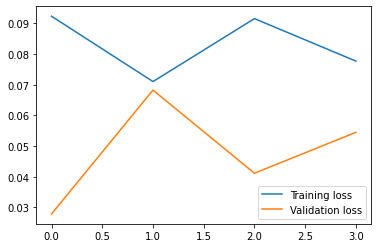

In [141]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();


In [142]:
model.evaluate(X_test, y_test)

36/36 [==============================] - 1s 14ms/step - loss: 0.0607


0.060652654618024826

Reconstruction error threshold: 1.3258068676844776


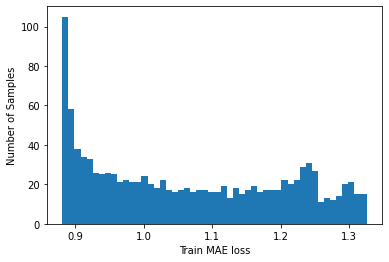

In [143]:

X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

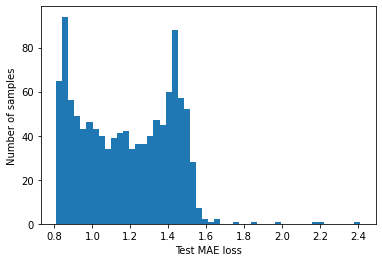

In [144]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [145]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['value'] = test[TIME_STEPS:]['value']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [146]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape


(389, 5)

In [147]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=scaler.inverse_transform(test_score_df['value']), name='values'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=scaler.inverse_transform(anomalies['value']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [148]:
for_eval = pd.read_csv('/content/drive/MyDrive/Yahoodataset/synthetic_2.csv')

In [149]:
len(for_eval)

1421

In [150]:
test_score_df

,timestamp,value,loss,threshold,anomaly
288,1970-01-01 00:00:01.417762800,-0.018983,0.921453,1.325807,False
289,1970-01-01 00:00:01.417766400,-0.071150,0.939960,1.325807,False
290,1970-01-01 00:00:01.417770000,-0.098359,0.959526,1.325807,False
291,1970-01-01 00:00:01.417773600,-0.122443,0.976358,1.325807,False
292,1970-01-01 00:00:01.417777200,-0.240566,0.989981,1.325807,False
...,...,...,...,...,...
1416,1970-01-01 00:00:01.421823600,1.034856,0.830246,1.325807,False
1417,1970-01-01 00:00:01.421827200,0.920675,0.833732,1.325807,False
1418,1970-01-01 00:00:01.421830800,0.936277,0.843624,1.325807,False
1419,1970-01-01 00:00:01.421834400,0.921900,0.850784,1.325807,False


In [151]:
for_eval

,timestamp,value,is_anomaly
0,1416726000,27.109888,0
1,1416729600,40.776442,0
2,1416733200,122.541469,0
3,1416736800,168.222793,0
4,1416740400,196.942108,0
...,...,...,...
1416,1421823600,1027.439798,0
1417,1421827200,914.594224,0
1418,1421830800,930.013750,0
1419,1421834400,915.804942,0


In [152]:
df21 = for_eval.iloc[288:]


In [153]:
df21

,timestamp,value,is_anomaly
288,1417762800,-14.074233,0
289,1417766400,-65.631832,0
290,1417770000,-92.522519,0
291,1417773600,-116.324788,0
292,1417777200,-233.065809,0
...,...,...,...
1416,1421823600,1027.439798,0
1417,1421827200,914.594224,0
1418,1421830800,930.013750,0
1419,1421834400,915.804942,0


In [154]:
test_score_df['anomaly']

288     False
289     False
290     False
291     False
292     False
        ...  
1416    False
1417    False
1418    False
1419    False
1420    False
Name: anomaly, Length: 1133, dtype: bool

In [155]:
anomaly_pred = test_score_df['anomaly']

In [156]:
anomaly_pred

288     False
289     False
290     False
291     False
292     False
        ...  
1416    False
1417    False
1418    False
1419    False
1420    False
Name: anomaly, Length: 1133, dtype: bool

In [157]:
df21 = df21.join(anomaly_pred)

In [158]:
df21

,timestamp,value,is_anomaly,anomaly
288,1417762800,-14.074233,0,False
289,1417766400,-65.631832,0,False
290,1417770000,-92.522519,0,False
291,1417773600,-116.324788,0,False
292,1417777200,-233.065809,0,False
...,...,...,...,...
1416,1421823600,1027.439798,0,False
1417,1421827200,914.594224,0,False
1418,1421830800,930.013750,0,False
1419,1421834400,915.804942,0,False


In [159]:
df21[['anomaly']] *= 1

In [160]:
df21

,timestamp,value,is_anomaly,anomaly
288,1417762800,-14.074233,0,0
289,1417766400,-65.631832,0,0
290,1417770000,-92.522519,0,0
291,1417773600,-116.324788,0,0
292,1417777200,-233.065809,0,0
...,...,...,...,...
1416,1421823600,1027.439798,0,0
1417,1421827200,914.594224,0,0
1418,1421830800,930.013750,0,0
1419,1421834400,915.804942,0,0


In [161]:
anomaly_pred

288     False
289     False
290     False
291     False
292     False
        ...  
1416    False
1417    False
1418    False
1419    False
1420    False
Name: anomaly, Length: 1133, dtype: bool

In [162]:
actual_anom1 = df21['is_anomaly']

In [163]:
actual_anom1

288     0
289     0
290     0
291     0
292     0
       ..
1416    0
1417    0
1418    0
1419    0
1420    0
Name: is_anomaly, Length: 1133, dtype: int64

In [164]:
from sklearn.metrics import accuracy_score

accuracy_score(actual_anom1, anomaly_pred)


0.6557811120917917

In [165]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actual_anom1, anomaly_pred)

array([[739, 385],
       [  5,   4]])

In [166]:
from sklearn.metrics import classification_report
print(classification_report(actual_anom1, anomaly_pred))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1124
           1       0.01      0.44      0.02         9

    accuracy                           0.66      1133
   macro avg       0.50      0.55      0.41      1133
weighted avg       0.99      0.66      0.79      1133

